# MNIST Digit Classification using Convolutional Neural Networks

## Objective
Build an end-to-end machine learning pipeline that:
- Trains a neural network on the MNIST dataset
- Classifies handwritten digit images (0–9)
- Performs inference on unseen test images

## Approach
- Dataset: MNIST (28×28 grayscale images)
- Model: Convolutional Neural Network (CNN)
- Framework: PyTorch
- Evaluation: Accuracy and qualitative error analysis


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


## Define Image Transforms

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),                 # Convert PIL → Tensor
    transforms.Normalize((0.1307,), (0.3081,))
])


## Load MNIST Dataset

In [3]:
train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)


## Create DataLoaders

In [4]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1000, shuffle=False)


## Define the Neural Network (CNN)

In [5]:
class DigitClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 * 24 * 24, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = x.view(x.size(0), -1)   # flatten
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


## Initialize Model, Loss, Optimizer

In [6]:
device = torch.device("cpu")
print("Using device:", device)

print("Using device:", device)


model = DigitClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


Using device: cpu
Using device: cpu


## Training Loop

Epoch 1
Training Loss: 0.1195
Epoch 2
Training Loss: 0.0341
Epoch 3
Training Loss: 0.0196
Epoch 4
Training Loss: 0.0116
Epoch 5
Training Loss: 0.0106


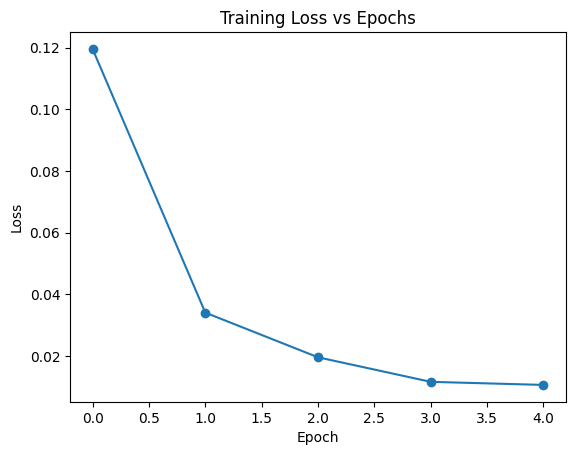

In [7]:
train_losses = []

def train(model, loader):
    model.train()
    total_loss = 0

    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)
    print(f"Training Loss: {avg_loss:.4f}")

for epoch in range(5):
    print(f"Epoch {epoch+1}")
    train(model, train_loader)

plt.plot(train_losses, marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss vs Epochs")
plt.show()




## Evaluate Accuracy

In [8]:
def test(model, loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    print(f"Test Accuracy: {100 * correct / total:.2f}%")

test(model, test_loader)






Test Accuracy: 98.76%


## Inference (Image → Digit)

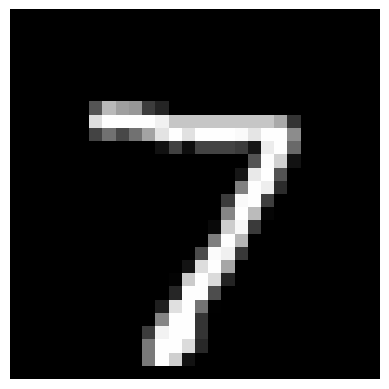

Predicted: 7
Actual: 7


In [9]:
def predict_digit(image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        output = model(image_tensor)
        return output.argmax(dim=1).item()

img, label = test_dataset[0]

plt.imshow(img.squeeze(), cmap="gray")
plt.axis("off")
plt.show()

print("Predicted:", predict_digit(img))
print("Actual:", label)


### Test Multiple Random MNIST Images

In [10]:
import random

def test_random_cases(dataset, n=10):
    model.eval()
    for i in random.sample(range(len(dataset)), n):
        img, label = dataset[i]
        pred = predict_digit(img)

        plt.imshow(img.squeeze(), cmap="gray")
        plt.title(f"Predicted: {pred} | Actual: {label}")
        plt.axis("off")
        plt.show()


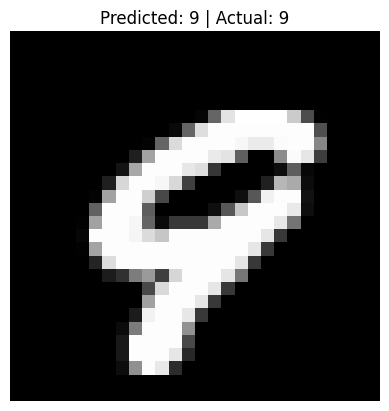

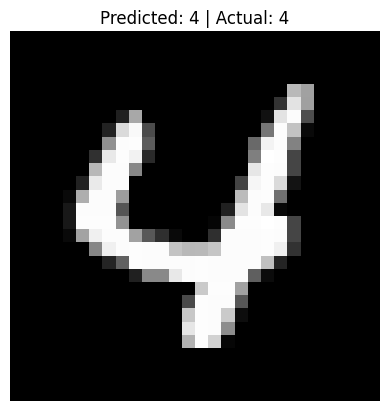

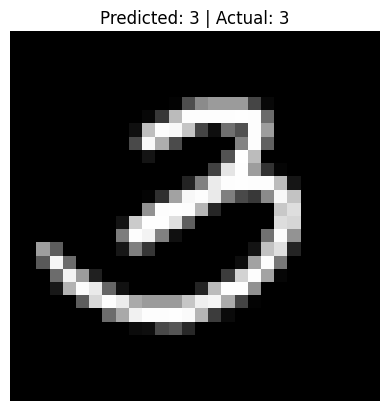

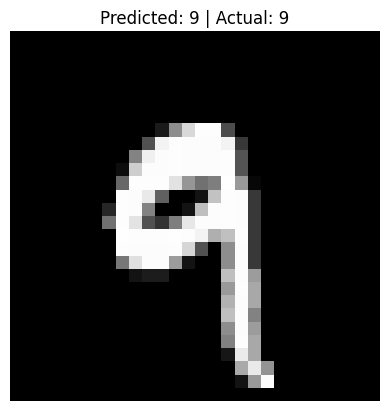

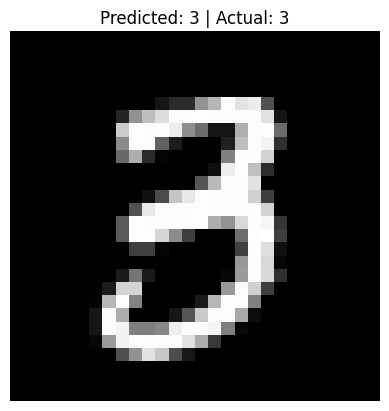

In [11]:
test_random_cases(test_dataset, n=5)


### Batch Inference + Accuracy Check (More “ML-ish”)

In [12]:
def batch_inference(model, loader, num_batches=1):
    model.eval()
    with torch.no_grad():
        for i, (images, labels) in enumerate(loader):
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(dim=1)

            print("Predictions:", preds[:10].cpu().numpy())
            print("Actual     :", labels[:10].numpy())
            break


In [13]:
batch_inference(model, test_loader)


Predictions: [7 2 1 0 4 1 4 9 5 9]
Actual     : [7 2 1 0 4 1 4 9 5 9]


### Find & Display WRONG Predictions

In [14]:
def show_misclassified(model, dataset, max_cases=5):
    model.eval()
    count = 0

    with torch.no_grad():
        for img, label in dataset:
            pred = predict_digit(img)
            if pred != label:
                plt.imshow(img.squeeze(), cmap="gray")
                plt.title(f"Wrong! Pred: {pred} | Actual: {label}")
                plt.axis("off")
                plt.show()
                count += 1
                if count == max_cases:
                    break


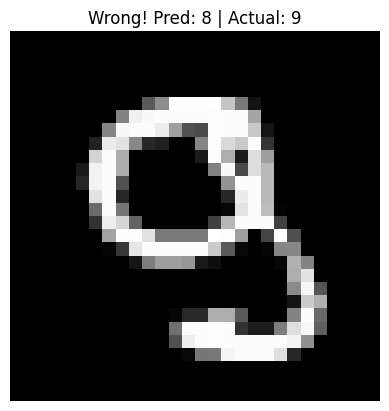

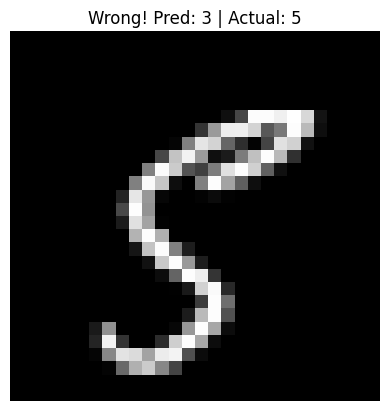

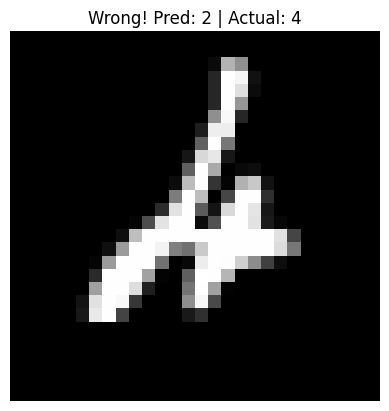

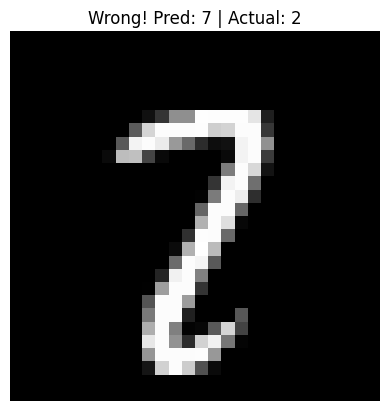

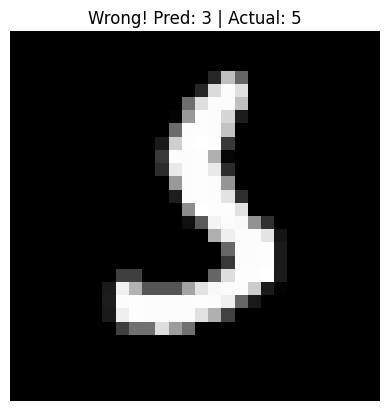

In [15]:
show_misclassified(model, test_dataset)


### Confidence Scores

In [16]:
import torch.nn.functional as F

def predict_with_confidence(image_tensor):
    model.eval()
    with torch.no_grad():
        image_tensor = image_tensor.unsqueeze(0).to(device)
        logits = model(image_tensor)
        probs = F.softmax(logits, dim=1)
        pred = probs.argmax(dim=1).item()
        confidence = probs.max().item()
    return pred, confidence


In [17]:
img, label = test_dataset[0]
pred, conf = predict_with_confidence(img)
print(f"Predicted: {pred}, Confidence: {conf:.2f}")


Predicted: 7, Confidence: 1.00


## Dataset Exploration
Visualizing sample digits from the MNIST dataset.


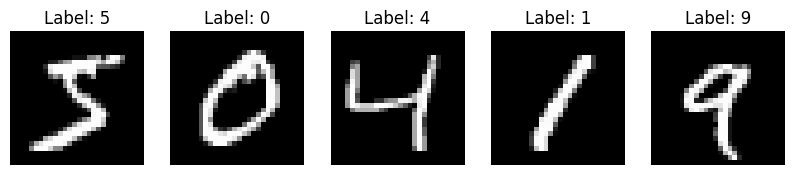

In [18]:
fig, axes = plt.subplots(1, 5, figsize=(10, 3))
for i, ax in enumerate(axes):
    img, label = train_dataset[i]
    ax.imshow(img.squeeze(), cmap="gray")
    ax.set_title(f"Label: {label}")
    ax.axis("off")
plt.show()


## Error Analysis using Confusion Matrix

The confusion matrix helps visualize how well the model performs on each digit
and highlights common misclassifications between visually similar digits.


## Confusion Matrix

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


Test Accuracy: 98.76%


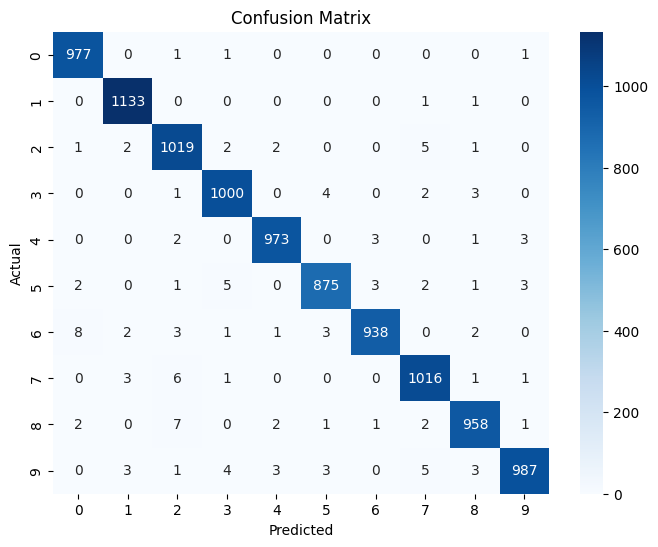

In [20]:
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
accuracy = sum(p == l for p, l in zip(all_preds, all_labels)) / len(all_labels)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


### Observations
- The model achieves high accuracy across most digits.
- Minor confusion is observed between visually similar digits such as 4 and 9.
- Overall performance indicates strong generalization on unseen test data.


## Final Conclusion

An end-to-end digit classification pipeline was successfully implemented using PyTorch.
The CNN model achieves high accuracy on the MNIST dataset and performs robustly on unseen data.
This project demonstrates understanding of data preprocessing, model design, training,
evaluation, and inference in a real-world machine learning workflow.
